In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import math
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from proj.show import imsshow
from skimage.metrics import structural_similarity

In [10]:
img_recon = np.load('data/data_after_prob1.npz')["recon"]
img_fully = np.load('data/cine.npz')['dataset']
#对图像进行归一化处理
def normalize(img):
    img = (img - img.min()) / (img.max() - img.min()+1e-8)
    return img
img_fully = normalize(img_fully)
img_recon = normalize(img_recon)
#获取test集
test_label = img_fully[150:]
test_data = img_recon[150:]
#把numpy数组转变成torch类型，构建loader
test_data = torch.from_numpy(test_data).float()
test_label = torch.from_numpy(test_label).float()
test = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_label), batch_size=5, shuffle=False)

In [11]:
class ResBlock_Mini(nn.Module):
    def __init__(self):
        super(ResBlock_Mini, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1) # 输出维度: (16, 20, 192, 192)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1) # 输出维度: (32, 10, 96, 96)
        self.conv7 = nn.Conv3d(32, 16, kernel_size=3, padding=1)
        self.conv8 = nn.Conv3d(16, 1, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.4)
    def forward(self, x):
        identity = x
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv7(out))
        out = self.conv8(out)
        out += identity
        return out

In [12]:
class ResBlock(nn.Module):
    def __init__(self):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1) # 输出维度: (16, 20, 192, 192)
        self.pool = nn.MaxPool3d(2, 2) # 输出维度: (16, 10, 96, 96)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1) # 输出维度: (32, 10, 96, 96)
        self.dropout = nn.Dropout(0.4)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1) # 输出维度: (16, 10, 96, 96)
        self.conv4 = nn.Conv3d(64, 128, kernel_size=3, padding=1) # 输出维度: (1, 20, 192, 192)
        self.conv5 = nn.Conv3d(128, 64, kernel_size=3, padding=1) # 输出维度: (16, 10, 96, 96)
        self.conv6 = nn.Conv3d(64, 32, kernel_size=3, padding=1)# 输出维度: (1, 20, 192, 192)
        self.conv7 = nn.Conv3d(32, 16, kernel_size=3, padding=1)
        self.conv8 = nn.Conv3d(16, 1, kernel_size=3, padding=1)
        self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)

    def forward(self, x):
        identity = x
        out = F.relu(self.conv1(x))
        out = self.pool(out)
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = F.relu(self.conv5(out))
        out = F.relu(self.conv6(out))
        out = F.relu(self.conv7(out))
        out = self.up(out)
        out = self.conv8(out)
        out += identity
        return out

In [18]:
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
name="resblock_128conv_withupdown_300epoch"
model=torch.load(f'.\\data\\problem2\\{name}.pth')
#model=torch.load('resblock_32conv_noupdown_500epoch.pth')

In [14]:
#计算重建前的PSNR和SSIM
with torch.no_grad():
    #print("lambda:",model.data_consistency_layer.print_lambda())
    test_loss = []
    test_ssim = []
    for i, data in enumerate(test, 0):
        data[0]=data[0].reshape(5,1,20,192,192)
        data[1]=data[1].reshape(5,1,20,192,192)
        inputs, labels=  data[0].to(device), data[1].to(device)
        outputs = inputs
        #20 * math.log10(max_intensity) - 10 * np.log10(compute_mse(reconstructed_im, target_im) + eps)
        test_loss .append( 20 * math.log10(1) - 10 * math.log10(criterion(outputs, labels).item()+1e-5))
        for j in range(5):
            test_ssim .append( structural_similarity(outputs[j][0].cpu().numpy(), labels[j][0].cpu().numpy()))
    print(f"Mean Test PSNR before Reconstruction: {sum(test_loss) / len(test_loss)}")
    print(f"Std Test PSNR before Reconstruction: {np.std(test_loss)}")
    print("------------------------------------------------------------")
    print(f"Mean Test SSIM before Reconstruction: {sum(test_ssim) / len(test_ssim)}")
    print(f"Std Test SSIM before Reconstruction: {np.std(test_ssim)}")


Mean Test PSNR before Reconstruction: 20.789583771229232
Std Test PSNR before Reconstruction: 0.8226013824445122
------------------------------------------------------------
Mean Test SSIM before Reconstruction: 0.6946488854028955
Std Test SSIM before Reconstruction: 0.07940761290376053


In [15]:
#计算重建后的PSNR和SSIM
with torch.no_grad():
    #print("lambda:",model.data_consistency_layer.print_lambda())
    test_loss = []
    test_ssim = []
    for i, data in enumerate(test, 0):
        data[0]=data[0].reshape(5,1,20,192,192)
        data[1]=data[1].reshape(5,1,20,192,192)
        inputs, labels=  data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        #20 * math.log10(max_intensity) - 10 * np.log10(compute_mse(reconstructed_im, target_im) + eps)
        test_loss .append( 20 * math.log10(1) - 10 * math.log10(criterion(outputs, labels).item()+1e-5))
        for j in range(5):
            test_ssim .append( structural_similarity(outputs[j][0].cpu().numpy(), labels[j][0].cpu().numpy()))
    print(f"Mean Test PSNR after Reconstruction: {sum(test_loss) / len(test_loss)}")
    print(f"Std Test PSNR after Reconstruction: {np.std(test_loss)}")
    print("------------------------------------------------------------")
    print(f"Mean Test SSIM after Reconstruction: {sum(test_ssim) / len(test_ssim)}")
    print(f"Std Test SSIM after Reconstruction: {np.std(test_ssim)}")
    #print(f"Validation PSNR: {test_loss / len(test)}")
    #print(f"Validation SSIM: {test_ssim / len(test) / 5}")

Mean Test PSNR after Reconstruction: 30.310642379573515
Std Test PSNR after Reconstruction: 0.6700099322728923
------------------------------------------------------------
Mean Test SSIM after Reconstruction: 0.9207329762705433
Std Test SSIM after Reconstruction: 0.023109954780859598


torch.Size([1, 20, 192, 192])


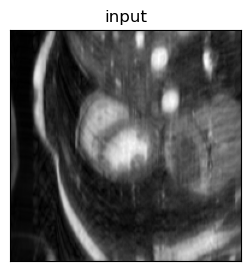

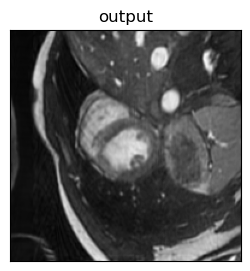

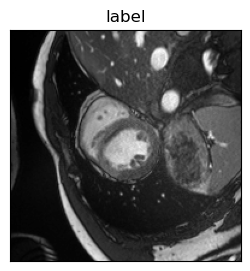

In [39]:
#显示训练集的第一个数据
inputs, labels = test_data[20], test_label[20]
inputs=inputs.reshape(1,1,20,192,192)
labels=labels.reshape(1,1,20,192,192)
outputs = model(inputs.to(device))
outputs = outputs.cpu().detach().numpy()
outputs = outputs.reshape(1,20,192,192)
imsshow (inputs[0].reshape(20,192,192),num_col=5,cmap='gray', is_colorbar=True,titles=["input"]*20)
imsshow(outputs[0],num_col=5,cmap='gray', is_colorbar=True,titles=["output"]*20)
imsshow(labels[0].reshape(20,192,192),num_col=5,cmap='gray', is_colorbar=True,titles=["label"]*20)